In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from compare_models import plot_confusion_matrix, calc_best_threshold, compare_models_roc_curve

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
DIRCTORY_PATH = 'results'
MODELS_NAMES = ['MLP', 'logistic regression', 'CNN_no_ftrs', 'LSTM_no_ftrs', 'CNN', 'LSTM', 'LSTM_MULTI']
MODELS_CSVs = [os.path.join(DIRCTORY_PATH, 'model_predictions', '{}_predictions.csv'.format(model)) for model in MODELS_NAMES]

Load the train/test data and the different predictions.

In [3]:
df_train = pd.read_csv(os.path.join(DIRCTORY_PATH, "df_train.csv"))
df_test = pd.read_csv(os.path.join(DIRCTORY_PATH, "df_test.csv"))
thresholds = dict()

for model_name, model_csv in zip(MODELS_NAMES, MODELS_CSVs):
    y_hat = pd.read_csv(model_csv, header=None).iloc[:, 0]
    thresholds[model_name] = calc_best_threshold([df_test.is_funny], [y_hat], [model_name])[model_name]
    df_test['{}_score'.format(model_name)] = y_hat
    df_test['{}_pred'.format(model_name)] = y_hat > thresholds[model_name]
    df_test['{}_score_minus_thres'.format(model_name)] = y_hat - thresholds[model_name]

Let's see some of the lines in the test data, including the different predictions.  
Note that the number mentioned is the difference between the score and the threshold chosen to separate funny and not-funny.  
Positive value = funny.  
Negative value = not-funny.  
We think about this value as "confidence", the higher it gets (in absolute value) the more "sure" the model with its prediction.  

In [4]:
cols_to_view = ['character', 'txt', 'start', 'end', 'is_funny'] + ['{}_score_minus_thres'.format(model_name) for model_name in MODELS_NAMES]
df_test[cols_to_view].head(3)

,character,txt,start,end,is_funny,MLP_score_minus_thres,logistic regression_score_minus_thres,CNN_no_ftrs_score_minus_thres,LSTM_no_ftrs_score_minus_thres,CNN_score_minus_thres,LSTM_score_minus_thres,LSTM_MULTI_score_minus_thres
0,JERRY,Have you ever called someone and were disappo...,0.620,5.011,True,-0.030322,0.065761,0.044882,0.030608,0.135955,0.271216,-0.096111
1,JERRY,You wanted the machine.,5.081,7.274,False,-0.118829,-0.080956,-0.138818,0.087590,-0.006023,0.172787,-0.092540
2,JERRY,You're always thrown off.,7.350,8.747,False,0.171618,0.106697,0.303107,0.063763,0.045943,0.132653,-0.164459


For example, the first sentence in the test data is Jerry opening a stand-up scene with   
'Have you ever called someone and were  disappointed when they answered?'  
and the prediction of the stroger models are correct (such as CNN and LSTM including addional features).

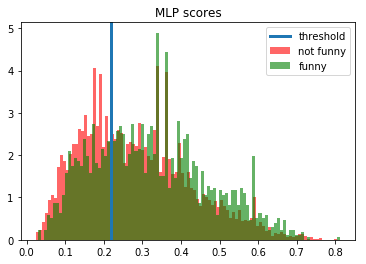

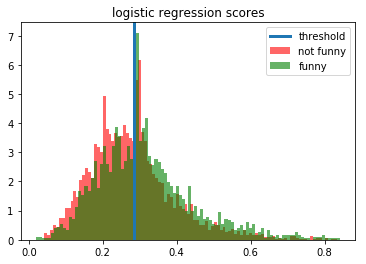

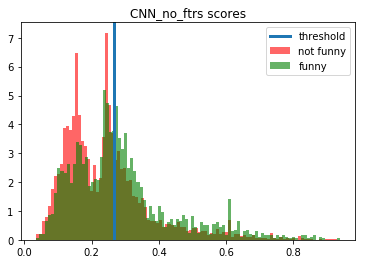

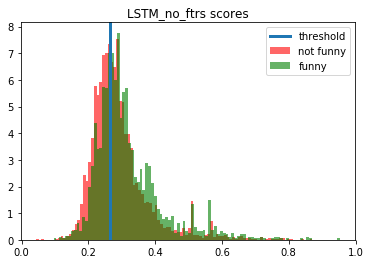

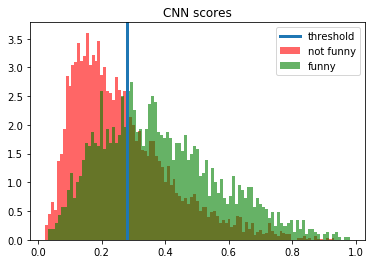

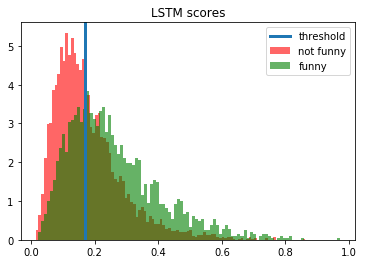

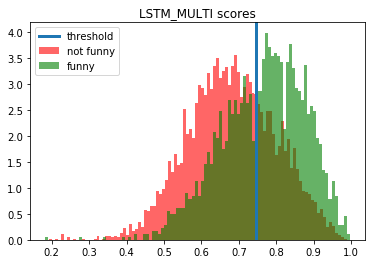

In [5]:
def plot_scores(model_name):
    y_hat = df_test['{}_score'.format(model_name)]
    y_hat_positive = y_hat[df_test['is_funny']]
    y_hat_negative = y_hat[~df_test['is_funny']]
    
    plt.hist(y_hat_negative, bins=100, color='red', alpha=0.6, label='not funny', density=1)
    plt.hist(y_hat_positive, bins=100, color='green', alpha=0.6, label='funny', density=1)
    plt.axvline(x=thresholds[model_name], label='threshold', linewidth=3)
    plt.legend()
    plt.title("{} scores".format(model_name))
    plt.show()

    
for model_name in MODELS_NAMES:
    plot_scores(model_name)

Let's look at the ROC-curve of the different models:

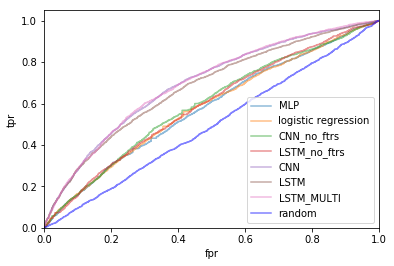

In [6]:
auc = compare_models_roc_curve([df_test['is_funny'] for model in MODELS_NAMES], 
                               [df_test['{}_score'.format(model)] for model in MODELS_NAMES], 
                               MODELS_NAMES, out_dir=None)

Let's see the confusion-matrices for the different models:

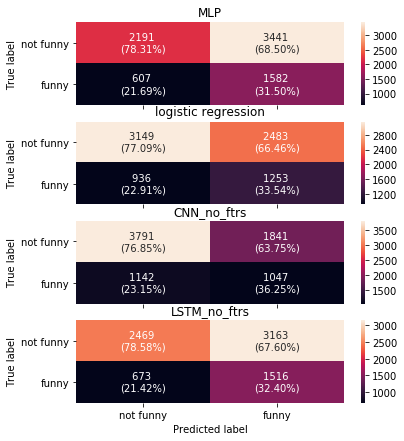

In [32]:
plot_confusion_matrix([df_test['is_funny'] for model in MODELS_NAMES[:4]],
                      [df_test['{}_pred'.format(model_name)] for model_name in MODELS_NAMES[:4]], 
                      MODELS_NAMES[:4], out_dir=None)

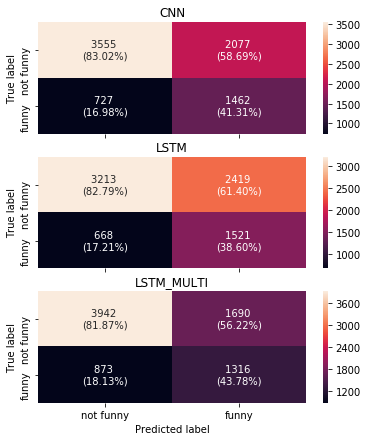

In [33]:
plot_confusion_matrix([df_test['is_funny'] for model in MODELS_NAMES[4:]],
                      [df_test['{}_pred'.format(model_name)] for model_name in MODELS_NAMES[4:]], 
                      MODELS_NAMES[4:], out_dir=None)

It's not perfect, but it definitely learned something :)  
We must remember that our data is quite noisy, so no-one can do it perfectly.  
Note that the additional features helped the models greatly.  

Let's compare how a good model (e.g. LSTM with multi-sentences) perform on different characters.

Confusion-matrix for JERRY


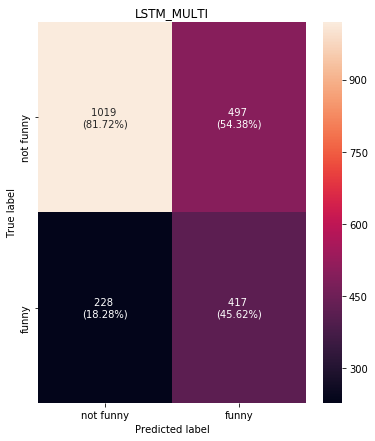

Confusion-matrix for GEORGE


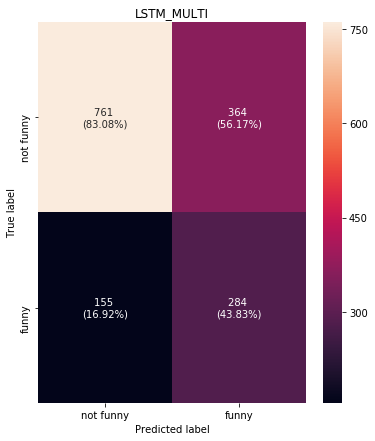

Confusion-matrix for ELAINE


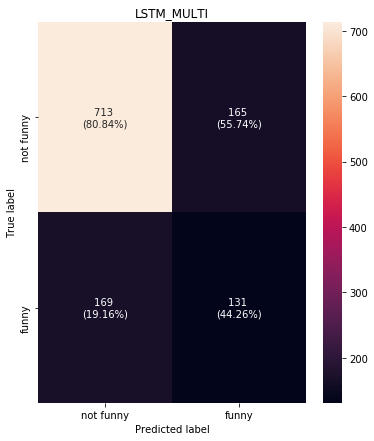

Confusion-matrix for KRAMER


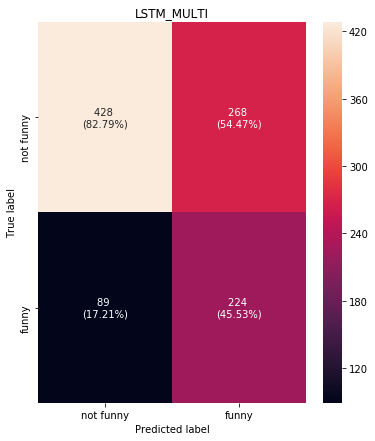

In [8]:
model = 'LSTM_MULTI'
for char in ['JERRY', 'GEORGE', 'ELAINE', 'KRAMER']:
    print("Confusion-matrix for {}".format(char))
    mask = df_test['character'] == char
    plot_confusion_matrix([df_test[mask]['is_funny']],
                          [df_test[mask]['{}_pred'.format(model)]], 
                          [model], out_dir=None)

## Examine Results Visually

Let's look at the "most severe" False-Positive (i.e. the model thought it's funny but it doesn't).  
We also add some context (4 sentences before the allegedly 'funny' sentence).

In [9]:
model_name = 'LSTM'
y_hat = df_test['{}_score'.format(model_name)]
y_hat_neg = y_hat[~df_test['is_funny']]
worst_fp_idx = y_hat_neg.iloc[np.argsort(y_hat_neg)[::-1][:1].values].index
for i in worst_fp_idx:
    print('\n{} score is {:.2}'.format(model_name, y_hat.iloc[i]))
    print(df_test.iloc[(i-5):(i+1)][['character', 'txt', 'is_funny']].to_string(index=False))


LSTM score is 0.86
character                                                txt  is_funny
  ELAINE                              "I'm very impressed"?     False
  ELAINE    You mean "pressed"  because it's a dry cleaner?     False
   JERRY                   Yeah, see? That's why I hate it.     False
   JERRY                          So come on, you wanna go?     False
  ELAINE  Well, what about the sleeping  arrangements in...     False
   JERRY    Well... Same bed,  and underwear and a T-shirt.     False


It doesn't seem so severe.  
By looking at it (without checking the label) one can think it's supposed to be funny...  
Let's look at some False-Negatives (i.e. the model thought it's not-funny but it is).

In [10]:
model_name = 'LSTM'
y_hat = df_test['{}_score'.format(model_name)]
y_hat_pos = y_hat[df_test['is_funny']]
worst_fn_idx = y_hat_pos.iloc[np.argsort(y_hat_pos)[3:5].values].index
for i in worst_fn_idx:
    print('\n{} score is {:.2}'.format(model_name, y_hat.iloc[i]))
    print(df_test.iloc[(i-5):(i+1)][['character', 'txt', 'is_funny']].to_string(index=False))


LSTM score is 0.03
character                                     txt  is_funny
    ALAN       I hope we can get  past all this.     False
    ALAN               Oh, past? We're way past.     False
    ALAN                 So you have a big head.     False
  ELAINE                                So what?      True
    ALAN  Goes well with the bump  in your nose.     False
  ELAINE                                   What?      True

LSTM score is 0.031
character                                                txt  is_funny
  ELAINE                                   I spoke to Alan.     False
  ELAINE  You know, I told him  I didn't wanna see him a...     False
  ELAINE                              Called me "big head."      True
   JERRY                                [SCOFFS]  Big head?     False
   JERRY                          It's almost a compliment.      True
  ELAINE  It's one of the nicest things  anyone's ever s...      True


These examples are quite difficult, it's not obvious that they're funny (just from the text).  

In [11]:
# Hard to see anything meaningful, let's try to set a threshold and look at all FP
FP_idx = y_hat_neg[y_hat_neg > threshold].index
fp_df = df_test.iloc[FP_idx, :]

NameError: name 'threshold' is not defined

In [ ]:
def plot_fp_column(df_test, fp_idx, column):
    fp_df = df_test.iloc[fp_idx, :]
    fp_column_norm = (fp_df.groupby(by=column).size() / df_test.groupby(by=column).size())
    plt.bar(fp_column_norm.index, height=fp_column_norm.values)
    plt.title("FP per {} normalized".format(column))
    plt.show()

In [ ]:
plot_fp_column(df_test, FP_idx, 'season')